# Recipe data exploration
This notebook will explore the data in the dataset we found from Kaggle here: https://www.kaggle.com/api/v1/datasets/download/kaggle/recipe-ingredients-dataset

The goal of this data exploration to see the rangae of recipes this dataset will help us train data to across a range of dimensions.

This notebook uses the following packages to help with data exploration: Pandas for data manipulation, Matlibplot for visualizing the data, Seaborn for more data visualization tools, and os for file system interaction.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud as wc
import os as os

#Basic Information
First, the data will be loaded into the workspace and basic information about the data investigated, including included columns and how the first entries are populated. Pandas can easily check missing values and many other pieces of information. In this case due to the dataset's freetext dimensions, Panda's describe function doesn't provide a particularly useful view into the data on its own. As shown below, there are a number of useful dimensions to this data that can be applied against my problem space: a recipe generator. Of particular interest are the ingredients field and the category field for prompting the user for what type of recipe they would like to find.

In [3]:

# Load the dataset
data_path = "data\\full_format_recipes.json"
df = pd.read_json(os.path.dirname(os.getcwd())+'\\'+data_path)

# Display basic information
print("Dataset Info:")
df.info()
print("\nFirst 5 Rows:")
print(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   directions   20111 non-null  object             
 1   fat          15908 non-null  float64            
 2   date         20111 non-null  datetime64[ns, UTC]
 3   categories   20111 non-null  object             
 4   calories     15976 non-null  float64            
 5   desc         13495 non-null  object             
 6   protein      15929 non-null  float64            
 7   rating       20100 non-null  float64            
 8   title        20111 non-null  object             
 9   ingredients  20111 non-null  object             
 10  sodium       15974 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB

First 5 Rows:
                                          directions   fat  \
0  [1. Place the stock

#Ingredients
To ensure useful recipes will be recommended, we must check the ingredients to make sure they will be able to be parsed by our training algorithms and runtime algorithms. The data should show many instances of particular ingredients, otherwise our algorithms will not correlate recipe recommendations with the ingredient list. Below we'll first see that the recipes often have many ingredients for our training to correlate against. Most recipes as seen below in this data set have near 10 ingredients. 

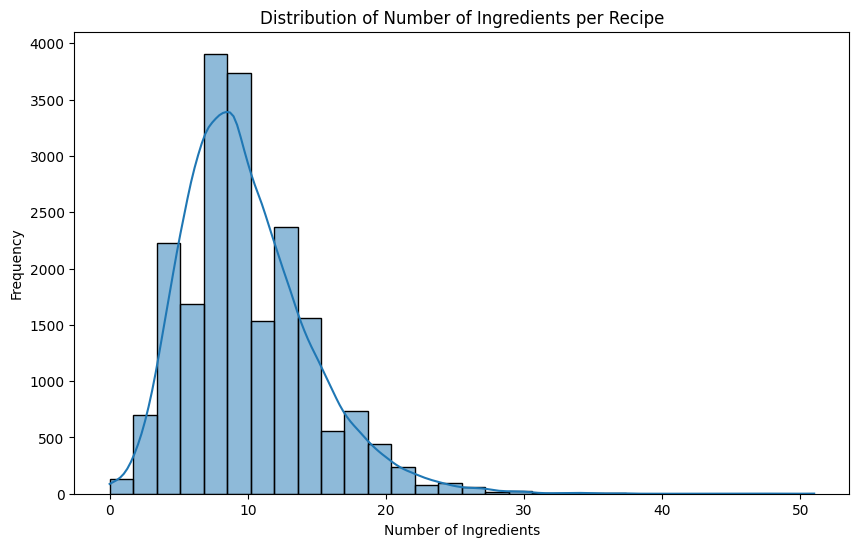

In [4]:
# Visualize the distribution of the number of ingredients per recipe
df['num_ingredients'] = df.apply(lambda row: len(pd.Series(row['ingredients'])), axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(df['num_ingredients'], bins=30, kde=True)
plt.title("Distribution of Number of Ingredients per Recipe")
plt.xlabel("Number of Ingredients")
plt.ylabel("Frequency")
plt.show()

#Ingredient Types
The list of ingredients as shown above is a free text field, meaning that recipe authors can write things into their recipes that won't necessarily be condusive to AI training. The next code block will strip some of the extraneous text out of the ingredient field to be better suited to data analysis and eventually training and validating AI products. Specifically, removing the quantity and unit of the ingredient from the text field will leave an ingredient list that will be easier to quantify how often it appears in recipes in turn improving the ability to correlate and train algorithms. As seen in the least common ingredients list below, they are often very unique descriptions of ingredients or directions built directly into the ingredient list. For the purposes of the recipe recommender, leaving this data as infrequent occurencies rather than stripping additional text to conform with other instances of the ingredient is an acceptable approximation of the data. 

In [5]:
# Top 10 most common ingredients
ingredient_counts = pd.DataFrame({'ing_qty': np.hstack(df.ingredients)})
# Note, regex101.com was very helpful to me developing this string to help strip the units and quantities out of my ingredient field
regpattern=r"(.*tbsps |.*tsps |.*tsp |.*tbsp |.*teaspoons |.*teaspoon |.*tablespoons |.*tablespoon |.*cups |.*cup |.*large |.*medium |.*small |.*cans |.*pounds |.*pound |.*lbs |.*lb |.*ounces |.*ounce |.*oz |.*slices |.*^[0-9] +)"
ingredient_counts = ingredient_counts.assign(ingredients=ingredient_counts['ing_qty'].replace(to_replace=regpattern,value=r"",regex=True))
ingredient_counts['ingredients'] = ingredient_counts['ingredients'].replace(to_replace='-',value=' ',regex=True)

print("\nTop 10 Most Common Ingredients:")
print(ingredient_counts['ingredients'].value_counts().head(10))
print("\nTop 10 Least Common Ingredients:")
print(ingredient_counts['ingredients'].value_counts().tail(10))


Top 10 Most Common Ingredients:
ingredients
sugar                     5209
salt                      4891
olive oil                 3999
water                     2808
all purpose flour         2661
fresh lemon juice         2472
extra virgin olive oil    1748
eggs                      1660
vegetable oil             1592
unsalted butter           1146
Name: count, dtype: int64

Top 10 Least Common Ingredients:
ingredients
all purpose flour, sifted after measuring                      1
eggs, at room temperature for 30 minutes                       1
Swiss cheese, cut into 1/4 inch dice (about 3/4 cup)           1
finely grated Parmigiano Reggiano (using a Microplane rasp)    1
diced drained oil packed sun dried tomatoes                    1
herbes de Provence* or salad herbs                             1
Additional minced orange peel                                  1
fully cooked bone in smoked ham, room temperature              1
48 (about) whole cloves                              

#Ingredient Variety
To give the recipe recommender customers an acceptable amount of variety in their recommendations, the ingredients should be varied across many different types. Below is a graph showing that even the most common ingredients are often not overwhelmingly used across recipes dataset. 

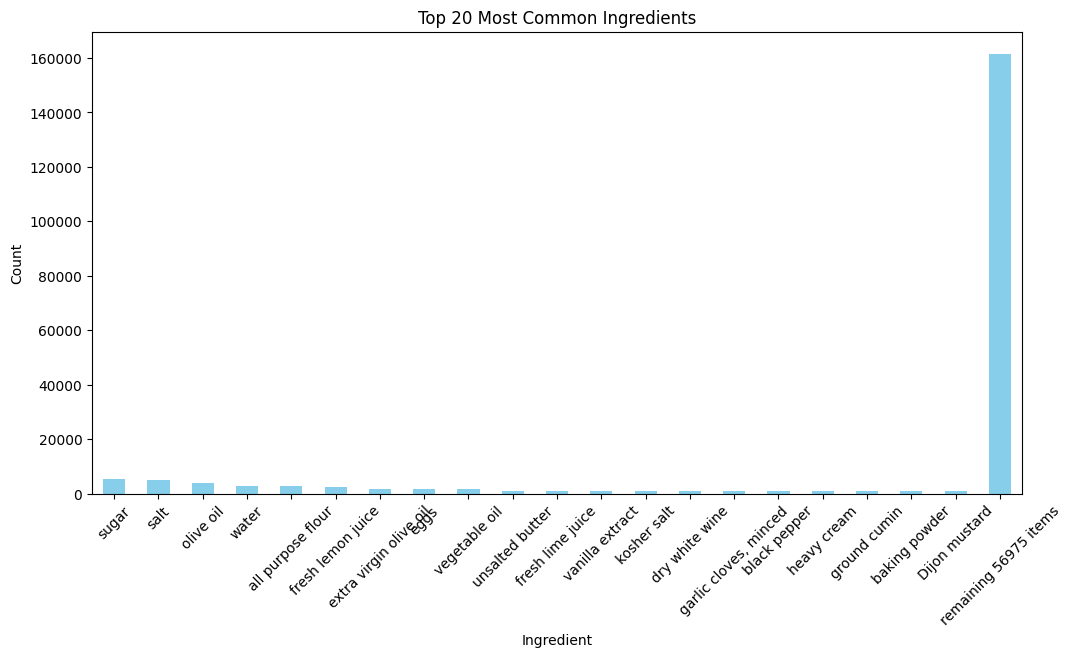

In [23]:

toping = ingredient_counts['ingredients'].value_counts()
toping_w_rest = toping.head(20)
if len(toping) > 20:
    toping_w_rest['remaining {0} items'.format(len(toping) - 20)] = sum(toping[20:])

# Visualizing top ingredients
plt.figure(figsize=(12, 6))
toping_w_rest.plot(kind='bar', color='skyblue')
plt.title("Top 20 Most Common Ingredients")
plt.xlabel("Ingredient")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Pairplot for potential correlations (if numeric features exist)
#if not df.select_dtypes(include=['number']).empty:
#    sns.pairplot(df.select_dtypes(include=['number']))
#    plt.show()

#Categories
Finally we'll investigate the categories field that recipe authors use to label their posts. As seen below, recipe authors use this field to add search metadata to label or futher categorize their recipes. This can be a useful correlation to train the recipe recommender algorithm against to give users the ability give input on the desired type of recipe. As this is also a free text field, authors can put a variety of information into this field, allow for our future algorithm to better align a recipe to the users desire.

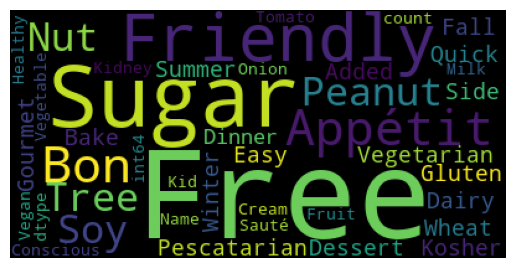

In [ ]:
wctext=pd.Series(np.hstack(df['categories']))
print(wctext.value_counts().head(20))

wordcloud = wc.WordCloud().generate(str(wctext.value_counts().head(30)))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()